# Analise dos dados do CAGED

## Importação de bibliotecas

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
from pyspark.sql.functions import col
from pyspark.sql import functions as F
from pyspark.sql import Row
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import os
import warnings
warnings.simplefilter('ignore')

## Importação dos dados

### Verificando consistência dos arquivos

#### Verificando se há linhas com quantidade de registro menor ou maior que a quantidade de colunas

*Função criada para identificar o delimitador de qualquer arquivo txt que esteja sendo analisado.*

In [2]:
def detect_delimiter(filepath):
    """
    :param filepath: Caminho absoluto do arquivo a ser analisado.
    :return: Retorna o delimitador utilizado no arquivo.
    """
    with open(filepath, 'r') as f:
        first_line = f.readline()
        delimiters = [',', ';', '\t']
        delimiter_counts = {delim: first_line.count(delim) for delim in delimiters}
        return max(delimiter_counts, key=delimiter_counts.get)

*Esta função verifica se as linhas do arquivo tem a mesma quantidade de colunas que o header*


In [3]:
def check_file_columns(filepath, delimiter):
    """
    :param filepath: Caminho absoluto do arquivo a ser analisado.
    :return: retorna a linha que contêm a quantidade de colunas diferente do header.
    """
    problematic_lines = []
    with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
        header = f.readline().strip().split(delimiter)
        num_cols = len(header)
        
        for i, line in enumerate(f, start=2):
            if len(line.strip().split(delimiter)) != num_cols:
                problematic_lines.append(i)

    return problematic_lines

*Lista todos caminhos absolutos dos arquivos a serem importados*

In [4]:
def list_txt_files(directory):
    """
    :param directory: Caminho para ser obter a lista de txt
    :return: Retorna o caminho absoluto de todos os arquivos listados na pasta
    """
    return [os.path.abspath(os.path.join(directory, file)) for file in os.listdir(directory) if file.endswith('.txt')]

In [5]:
path = '/home/marceloborges/Datasets/CAGED_aggregated/'

In [6]:
files = list_txt_files(path)

### Configuração do ambiente spark

In [7]:
spark = SparkSession.builder.appName("CagedProcessing").getOrCreate()

23/10/14 11:11:38 WARN Utils: Your hostname, pop-os resolves to a loopback address: 127.0.1.1; using 192.168.2.15 instead (on interface wlo1)
23/10/14 11:11:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/14 11:11:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/14 11:11:39 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


#### Verificando se há erros no dataset

*Criando um dataframe para receber informações caso tenha algum erro no dataset*

In [8]:
schema = StructType([
    StructField("File", StringType(), True),
    StructField("Issue", StringType(), True),
    StructField("Details", StringType(), True)
])

df_errors = spark.createDataFrame([], schema)

In [9]:
for file in tqdm(files, desc="Processing files", unit="files"):
    delimiter = detect_delimiter(file)
    try:
        spark_df = spark.read.option("delimiter", delimiter).csv(file)
    except Exception as e:
        problematic_lines = check_file_columns(file, delimiter)
        for line in problematic_lines:
            new_row = Row(File=file, Issue="Tokenization Error", Details=f"Line {line}")
            df_errors = df_errors.union(spark.createDataFrame([new_row]))



Processing files: 100%|██████████| 116/116 [00:07<00:00, 15.72files/s]


In [10]:
df_errors.show()

+----+-----+-------+
|File|Issue|Details|
+----+-----+-------+
+----+-----+-------+



## Exploratory Data Analysis - EDA

#### Criação do dataframe

In [11]:
df = spark.read.option("delimiter", delimiter).option('header','true').csv(path + "*.txt")

#### Identificando o schema do dataframe

*Foi identificado que na coluna salário possui muitas informações nulas, resolvemos excluir este dado*

In [12]:
df.filter(F.col("salário").isNull()).count()

127914

In [13]:
df = df.na.drop(subset=["salário"])

#### Exclusão de colunas desnecessárias para o estudo

In [14]:
excluded_col_list = ['raçacor','indtrabintermitente','indtrabparcial','tamestabjan','indicadoraprendiz','competênciadec','indicadordeforadoprazo','unidadesaláriocódigo','valorsaláriofixo']

In [15]:
df = df.drop(*excluded_col_list)

*Foi identificado também que todas as colunas estão formato de string e com os sinais de separação de milhares e casas decimais seguindo o formato brasileiro, tivemos que inverter os sinais e converter *

In [16]:
df.printSchema()

root
 |-- competênciamov: string (nullable = true)
 |-- região: string (nullable = true)
 |-- uf: string (nullable = true)
 |-- município: string (nullable = true)
 |-- seção: string (nullable = true)
 |-- subclasse: string (nullable = true)
 |-- saldomovimentação: string (nullable = true)
 |-- cbo2002ocupação: string (nullable = true)
 |-- categoria: string (nullable = true)
 |-- graudeinstrução: string (nullable = true)
 |-- idade: string (nullable = true)
 |-- horascontratuais: string (nullable = true)
 |-- sexo: string (nullable = true)
 |-- tipoempregador: string (nullable = true)
 |-- tipoestabelecimento: string (nullable = true)
 |-- tipomovimentação: string (nullable = true)
 |-- tipodedeficiência: string (nullable = true)
 |-- salário: string (nullable = true)
 |-- origemdainformação: string (nullable = true)



In [18]:
excessao_list=['horascontratuais','salário']

In [19]:
for col in excessao_list:
    df = df.withColumn(col, F.regexp_replace(F.col(col), ",", "."))

*A maioria das colunas são chaves estrangeiras, com poucas exceções, portanto, iremos identificar estes campos que são valores calculados (medidas), convertê-los para float e os demais para integer*

In [20]:
for coluna in df.columns:
    if coluna in excessao_list:
        df = df.withColumn(coluna, F.col(coluna).cast(FloatType()))
    else:
        df = df.withColumn(coluna, F.col(coluna).cast(IntegerType())) 

In [21]:
df.printSchema()

root
 |-- competênciamov: integer (nullable = true)
 |-- região: integer (nullable = true)
 |-- uf: integer (nullable = true)
 |-- município: integer (nullable = true)
 |-- seção: integer (nullable = true)
 |-- subclasse: integer (nullable = true)
 |-- saldomovimentação: integer (nullable = true)
 |-- cbo2002ocupação: integer (nullable = true)
 |-- categoria: integer (nullable = true)
 |-- graudeinstrução: integer (nullable = true)
 |-- idade: integer (nullable = true)
 |-- horascontratuais: float (nullable = true)
 |-- sexo: integer (nullable = true)
 |-- tipoempregador: integer (nullable = true)
 |-- tipoestabelecimento: integer (nullable = true)
 |-- tipomovimentação: integer (nullable = true)
 |-- tipodedeficiência: integer (nullable = true)
 |-- salário: float (nullable = true)
 |-- origemdainformação: integer (nullable = true)



#### Importação das tabelas dimensões

*Precisamos ler as descrições das fkeys que estão presente nos arquivos de dimensão*

In [22]:
dfs = {}

In [23]:
dimension_path = '/home/marceloborges/Documentos/Pós gradução/4 - Spark/dataframes_csv'

In [24]:
dimension_files = [f for f in os.listdir(dimension_path) if f.endswith('.csv')]

In [25]:
for file in dimension_files:
    path_dimension_file = os.path.join(dimension_path, file)
    dimension = os.path.splitext(file)[0]
    dfs[dimension] = spark.read.csv(path_dimension_file, header=True, inferSchema=True)

*Criaremos uma coluna no qual retire do campo competência que está no formato mês/ano (202309) somente o ano, para que possamos fazer as agregações*

In [26]:
df= df.withColumn("Ano", F.substring("competênciamov", 1, 4))

*Neste trecho, iremos substituir as colunas categóricas, ou seja, as colunas nos quais iremos fazer agregações e substituir o FKeys pela descrição contida nas tabelas de dimensões*

In [27]:
col_category = ['região', 'uf', 'município', 'graudeinstrução','sexo']

*Este trecho faz o seguinte, vou iterar a lista col_category e para cada coluna iterada, irei verificar se a coluna contêm no dataframe (dfs), caso seja verdadeiro, criamos um dicionário contendo a chave e o valor. Criamos uma lista vazia, e para cada chave (k) e valor (v) no dicionário (dict_mapping) nós adicionamos no map_list os valores literais de chave e valor. Criamos uma expressão do pyspark que irá substituir os dados e em seguida, aplicamos a expressão e obtemos  o dataframe já com os valores trocados.*

In [28]:
for col in col_category:
    if col in dfs:
        dict_mapping = {row['Código']: row['Descrição'] for row in dfs[col].collect()}
        map_list = []        
        for k, v in dict_mapping.items():
            map_list.append(F.lit(k))
            map_list.append(F.lit(v))            
        map_expr = F.create_map(map_list)
        df = df.withColumn(col, map_expr[F.col(col)])

*Criamos um filtro com todas as atividades relacionadas com Enfermagem*

In [29]:
employee_filter = [223505, 223510, 223515, 223520, 223525, 223530, 223535, 223540, 223545, 223550, 223555, 223560, 223565]

*Criamos um filtro de algumas capitais brasileiras para fazermos comparações, são elas: Minha bela Goiânia, São Paulo, Rio de Janeiro, Belo Horizonte e Salvador*

In [30]:
city_filter = ['Sp-Sao Paulo','Go-Goiania','Ba-Salvador','Rj-Rio de Janeiro','Mg-Belo Horizonte']

*Criamos o dataframe hiring_state, nele manteremos todos os filtros daqui em diante*

In [31]:
df_hiring_state = df.filter(
    (df['cbo2002ocupação'].isin(employee_filter)) &
    (df['município'].isin(city_filter)) &
    (df['Ano'] >= 2020) & (df['Ano'] <= 2023)
)

In [32]:
df_grouped = df_hiring_state.groupBy('Ano', 'uf').agg(
    F.sum('saldomovimentação').alias('Saldo')
).orderBy('Ano', 'uf')

*Não encontrei uma forma direta para plotar em gráficos um dataframe spark, a forma que encontrei é convertendo para o formato pandas*

In [33]:
graph_hiring_df = df_grouped.toPandas()

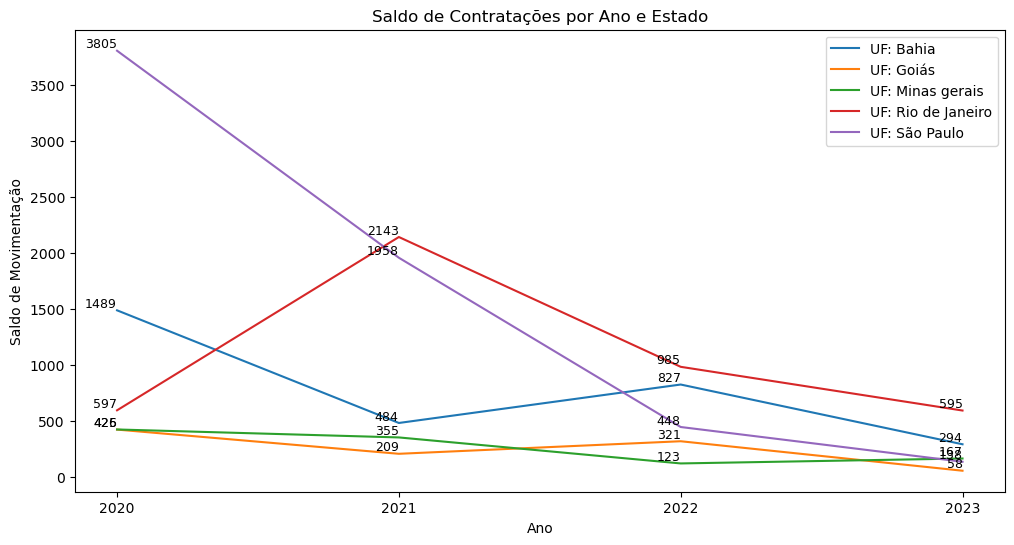

In [34]:
plt.figure(figsize=(12, 6))

for uf in graph_hiring_df['uf'].unique():
    subset = graph_hiring_df[graph_hiring_df['uf'] == uf]
    plt.plot(subset['Ano'], subset['Saldo'], label=f"UF: {uf}")
    for x, y in zip(subset['Ano'], subset['Saldo']):
        plt.text(x, y, f"{y}", fontsize=9, va='bottom', ha='right')

plt.xlabel('Ano')
plt.ylabel('Saldo de Movimentação')
plt.title('Saldo de Contratações por Ano e Estado')
plt.legend()
plt.show()

*Irei deletar os dataframes, após a plotagem do gráfico para ocupar menos espaço em memória*

In [35]:
df_gender = df_hiring_state.groupBy("sexo").agg(
    F.sum("saldomovimentação").alias("Saldo_Contratações")
)
graph_gender_df =  df_gender.toPandas()

In [36]:
graph_gender_df

,sexo,Saldo_Contratações
0,Homem,2689
1,Mulher,13158


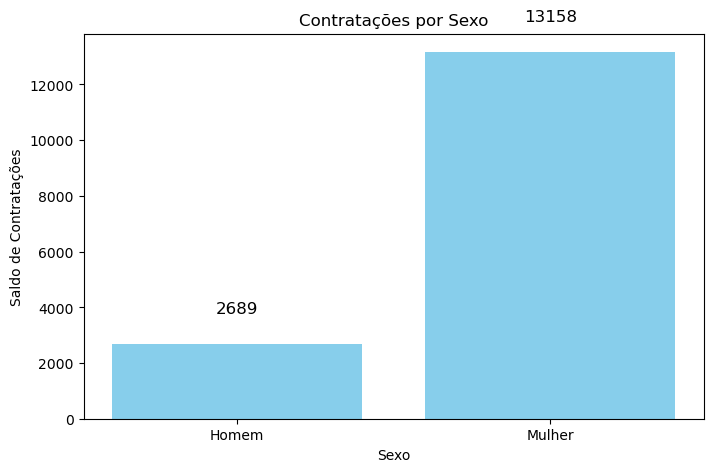

In [37]:
plt.figure(figsize=(8, 5))
plt.bar(graph_gender_df['sexo'], graph_gender_df['Saldo_Contratações'], color='skyblue')

# Adicionar rótulos
plt.title('Contratações por Sexo')
plt.xlabel('Sexo')
plt.ylabel('Saldo de Contratações')

# Exibir os valores acima das barras
for i, v in enumerate(graph_gender_df['Saldo_Contratações']):
    plt.text(i, v + 1000, str(v), ha='center', va='bottom', fontsize=12)

In [38]:
age_df = df_hiring_state.withColumn(
    "faixa_etaria",
    F.when(F.col("idade") < 30, "Abaixo de 30")
    .when((F.col("idade") >= 30) & (F.col("idade") <= 50), "Entre 30 e 50")
    .otherwise("Acima de 50")
)

In [39]:
age_df = age_df.groupBy("faixa_etaria").agg(
    F.sum("saldomovimentação").alias("Saldo_Contratações")
)
df_age = age_df.toPandas()

In [40]:
df_age = df_age.sort_index()

*Vamos aplicar os filtros que corresponderá aos cargos que definimos (enfermeiras) e vamos criar o gráfico para que seja analisada qual foi o saldo entre contratações de desligamentos. Vamos fazer isso para algumas capitais Brasileiras*

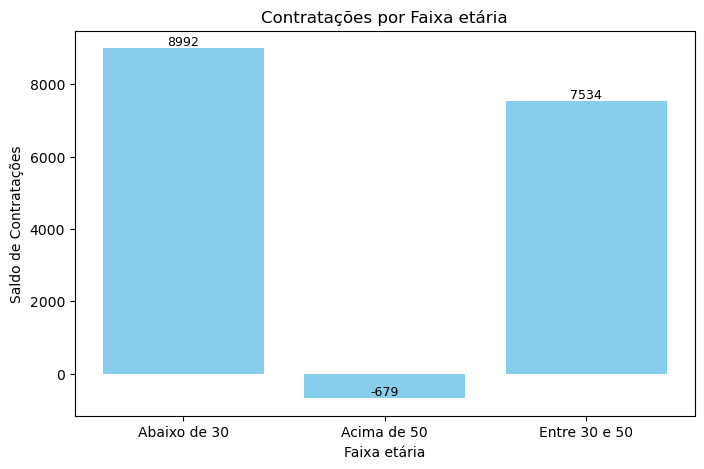

In [41]:
plt.figure(figsize=(8, 5))
plt.bar(df_age['faixa_etaria'], df_age['Saldo_Contratações'], color='skyblue')
for x, y in zip(df_age['faixa_etaria'], df_age['Saldo_Contratações']):
        plt.text(x, y, f"{y}", fontsize=9, va='bottom', ha='center') 
plt.title('Contratações por Faixa etária')
plt.xlabel('Faixa etária')
plt.ylabel('Saldo de Contratações')
plt.show()

### Gráficos novos, conforme solicitado no enunciado

In [42]:
df_salary_state_year = df_hiring_state.filter(F.col('cbo2002ocupação').isin(employee_filter)) \
                         .filter(F.col('município').isin(city_filter)) \
                         .groupBy('município', 'Ano') \
                         .agg(F.avg('salário').alias('Média_Salarial'))

In [43]:
df_salary_state_year_pd = df_salary_state_year.toPandas()


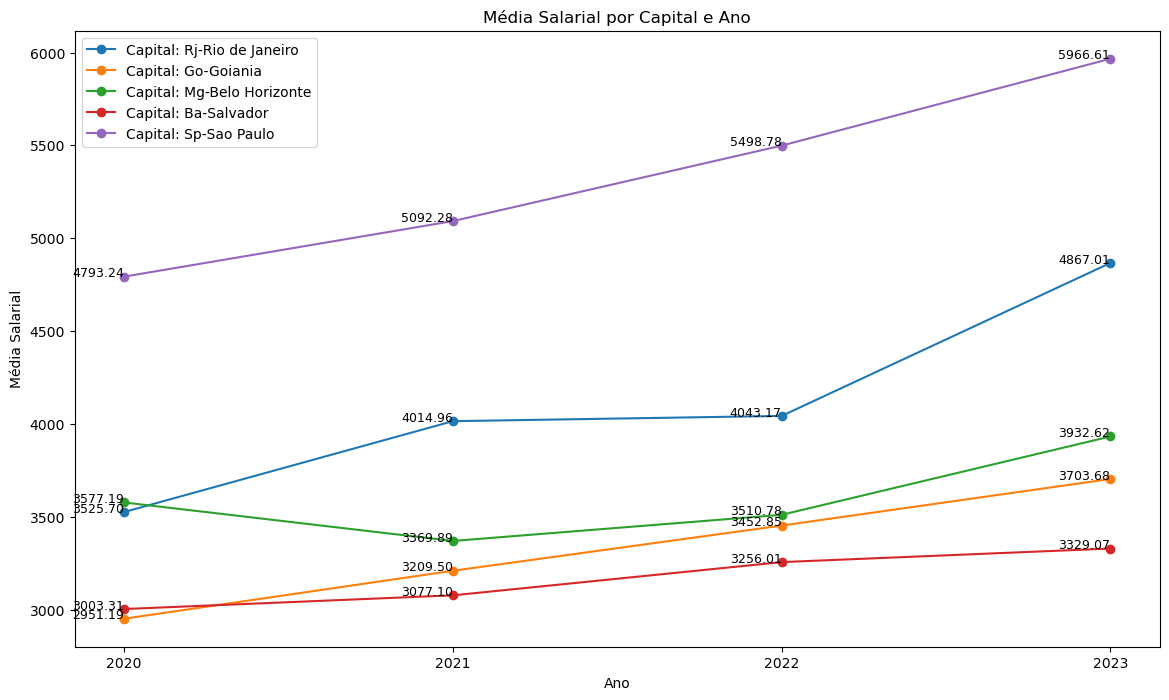

In [44]:
plt.figure(figsize=(14, 8))
unique_city = df_salary_state_year_pd['município'].unique()
unique_years = sorted(df_salary_state_year_pd['Ano'].unique())
for city in unique_city:
    subset = df_salary_state_year_pd[df_salary_state_year_pd['município'] == city]
    plt.plot(subset['Ano'], subset['Média_Salarial'], marker='o', label=f"Capital: {city}")
    for x, y in zip(subset['Ano'], subset['Média_Salarial']):
        plt.text(x, y, f"{y:.2f}", fontsize=9, ha='right')
plt.xlabel('Ano')
plt.ylabel('Média Salarial')
plt.title('Média Salarial por Capital e Ano')
plt.xticks(unique_years)
plt.legend()
plt.show()

In [45]:
df_old_avg = df_hiring_state.withColumn('capital', F.col('município')).groupBy('capital').agg(F.avg('idade').alias('media_idade'))
df_old_avg_pd = df_old_avg.toPandas()

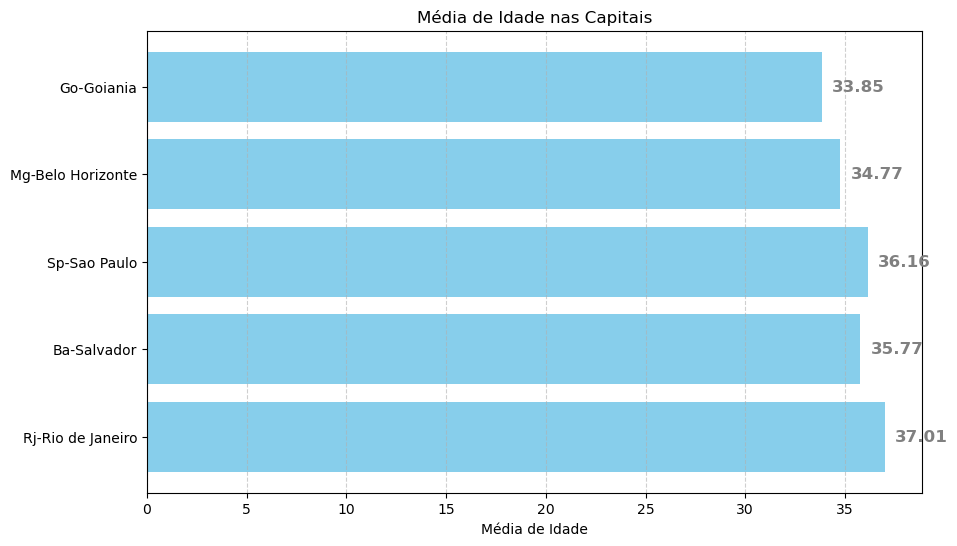

In [46]:
plt.figure(figsize=(10, 6))
plt.barh(df_old_avg_pd['capital'], df_old_avg_pd['media_idade'], color='skyblue')
plt.xlabel('Média de Idade')
plt.title('Média de Idade nas Capitais')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
for i, v in enumerate(df_old_avg_pd['media_idade']):
    plt.text(v + 0.5, i, f'{v:.2f}', va='center', fontsize=12, fontweight='bold', color='gray')

plt.show()